<a href="https://colab.research.google.com/github/nimeshayasith/Computer_vision_Assignment/blob/main/4624_Question_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- STEP 1: RECONNECT GOOGLE DRIVE (Fixes Error 107) ---
from google.colab import drive
import os

# Force a remount to re-establish the broken connection
drive.mount('/content/drive', force_remount=True)

# Point back to your project folder
project_path = '/content/drive/MyDrive/CV_Assessment_01'
if os.path.exists(project_path):
    os.chdir(project_path)
    print("Drive reconnected and directory set successfully!")
else:
    print("Drive mounted, but folder not found. Please check your folder name.")

Mounted at /content/drive
Drive reconnected and directory set successfully!


In [ ]:
import os

# Update this path if you named your folder something else
project_path = '/content/drive/MyDrive/CV_Assessment_01'

# Change the current working directory
os.chdir(project_path)

# Verify you are in the right place
print("Current Working Directory:", os.getcwd())
print("Files in Dataset folder:", os.listdir('Dataset'))

Current Working Directory: /content/drive/MyDrive/CV_Assessment_01
Files in Dataset folder: ['IPCV_ ASSIGNMENT_01_DATABASE.zip', 'IPCV_ ASSIGNMENT_01_DATABASE']


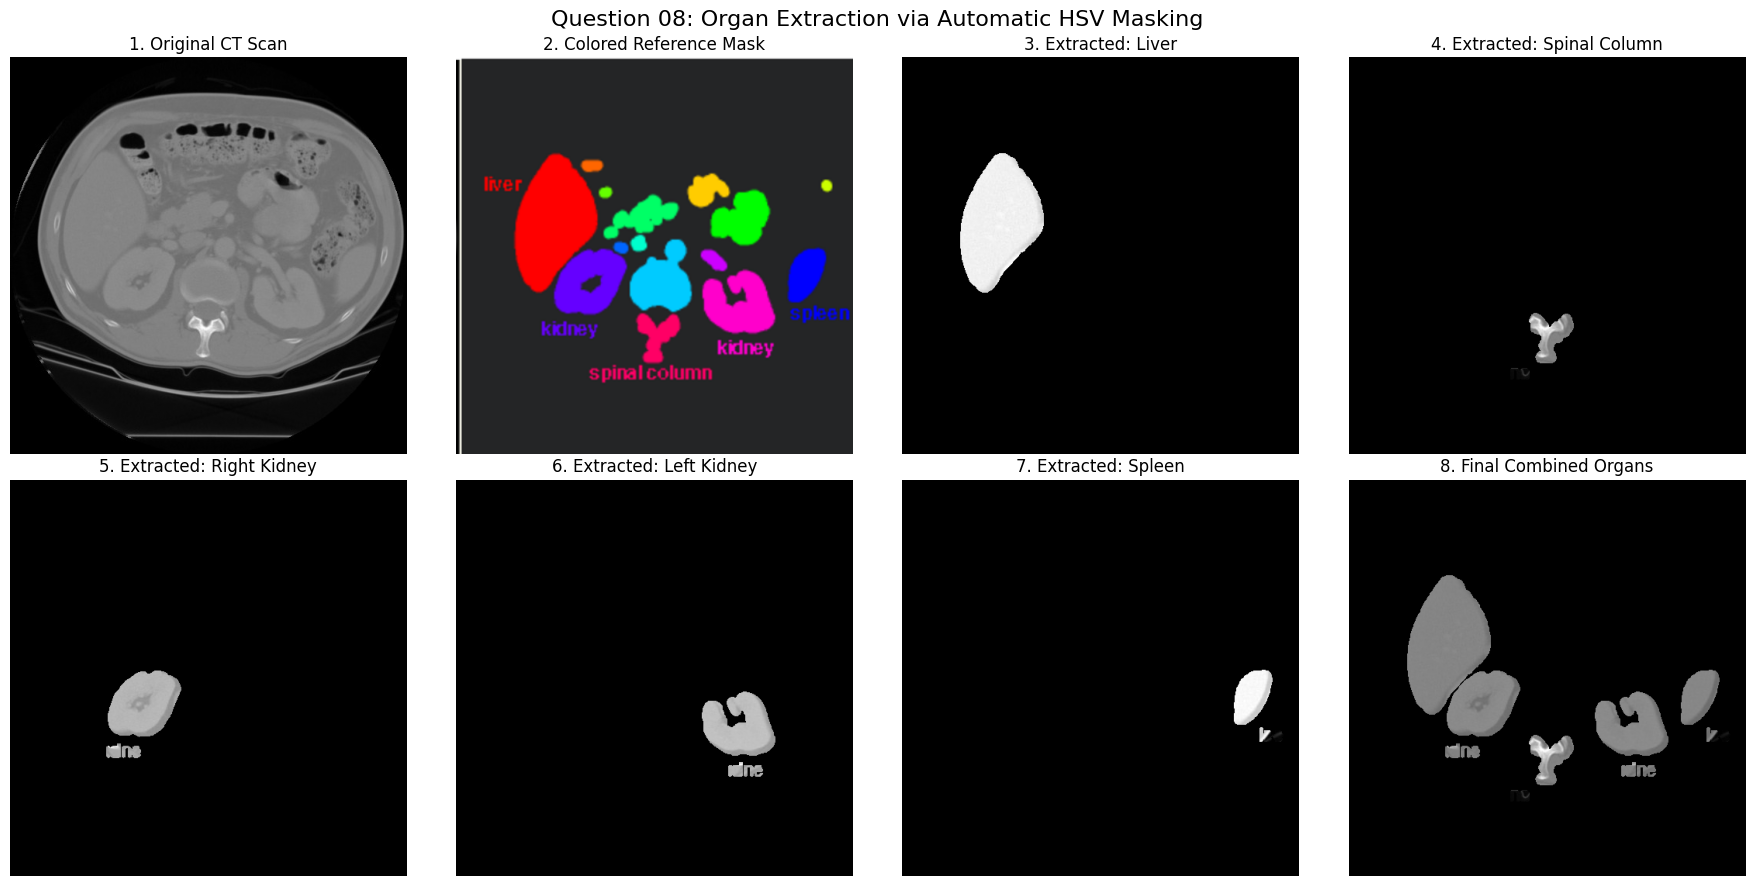

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# STEP 1: Load images
# ==========================================
img_4_path = 'Dataset/IPCV_ ASSIGNMENT_01_DATABASE/Images_ For_Preliminary_Part/Image_4.jpg'
ct_image = cv2.imread(img_4_path, cv2.IMREAD_GRAYSCALE)

# Load your ALREADY CROPPED colored mask
mask_path = 'Dataset/IPCV_ ASSIGNMENT_01_DATABASE/Images_ For_Preliminary_Part/colored_mask.png'
colored_mask = cv2.imread(mask_path)

if ct_image is None or colored_mask is None:
    print("Error: Could not load one or both images. Check file paths!")
else:
    # ==========================================
    # STEP 2: Resize mask if it doesn't match CT image size
    # ==========================================
    # NO AUTO-CROP NEEDED! We just resize your perfect mask to match the CT scan.
    ct_h, ct_w = ct_image.shape
    colored_mask_resized = cv2.resize(colored_mask, (ct_w, ct_h))

    # ==========================================
    # STEP 3: Define HSV color ranges for each organ
    # ==========================================
    organ_colors = {
        'Liver (Red)': {
            'lower1': np.array([0, 150, 100]), 'upper1': np.array([10, 255, 255]),
            'lower2': np.array([170, 150, 100]), 'upper2': np.array([179, 255, 255])
        },
        'Right Kidney (Purple)': {
            'lower1': np.array([125, 100, 100]), 'upper1': np.array([140, 255, 255])
        },
        'Left Kidney (Magenta)': {
            'lower1': np.array([145, 100, 100]), 'upper1': np.array([160, 255, 255])
        },
        'Spleen (Blue)': {
            'lower1': np.array([110, 150, 100]), 'upper1': np.array([125, 255, 255])
        },
        'Spinal Column (Pink)': {
            'lower1': np.array([160, 100, 100]), 'upper1': np.array([175, 255, 255])
        }
    }

    # ==========================================
    # STEP 4: Convert mask to HSV and prepare canvases
    # ==========================================
    hsv_mask = cv2.cvtColor(colored_mask_resized, cv2.COLOR_BGR2HSV)
    extracted_organs = {}
    combined_extracted = np.zeros_like(ct_image)

    # ==========================================
    # STEP 7: Loop through all organs to extract each one
    # ==========================================
    for organ_name, ranges in organ_colors.items():
        mask1 = cv2.inRange(hsv_mask, ranges['lower1'], ranges['upper1'])

        # Red wraps around the HSV spectrum, so Liver needs two combined masks
        if 'upper2' in ranges:
            mask2 = cv2.inRange(hsv_mask, ranges['lower2'], ranges['upper2'])
            binary_mask = cv2.bitwise_or(mask1, mask2)
        else:
            binary_mask = mask1

        # ==========================================
        # STEP 5: Remove small noisy areas using contour area filtering
        # ==========================================
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        clean_binary_mask = np.zeros_like(binary_mask)

        for cnt in contours:
            if cv2.contourArea(cnt) > 200: # Ignore tiny text noise
                cv2.drawContours(clean_binary_mask, [cnt], -1, 255, thickness=cv2.FILLED)

        # ==========================================
        # STEP 6: Apply mask on CT image to isolate the organ
        # ==========================================
        isolated_organ = cv2.bitwise_and(ct_image, ct_image, mask=clean_binary_mask)

        combined_extracted = cv2.bitwise_or(combined_extracted, isolated_organ)
        extracted_organs[organ_name] = isolated_organ

    # ==========================================
    # STEP 8: Display results
    # ==========================================
    fig, axes = plt.subplots(2, 4, figsize=(18, 9))
    fig.suptitle("Question 08: Organ Extraction via Automatic HSV Masking", fontsize=16)

    axes[0, 0].imshow(ct_image, cmap='gray')
    axes[0, 0].set_title("1. Original CT Scan")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(cv2.cvtColor(colored_mask_resized, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title("2. Colored Reference Mask")
    axes[0, 1].axis('off')

    axes[0, 2].imshow(extracted_organs['Liver (Red)'], cmap='gray')
    axes[0, 2].set_title("3. Extracted: Liver")
    axes[0, 2].axis('off')

    axes[0, 3].imshow(extracted_organs['Spinal Column (Pink)'], cmap='gray')
    axes[0, 3].set_title("4. Extracted: Spinal Column")
    axes[0, 3].axis('off')

    axes[1, 0].imshow(extracted_organs['Right Kidney (Purple)'], cmap='gray')
    axes[1, 0].set_title("5. Extracted: Right Kidney")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(extracted_organs['Left Kidney (Magenta)'], cmap='gray')
    axes[1, 1].set_title("6. Extracted: Left Kidney")
    axes[1, 1].axis('off')

    axes[1, 2].imshow(extracted_organs['Spleen (Blue)'], cmap='gray')
    axes[1, 2].set_title("7. Extracted: Spleen")
    axes[1, 2].axis('off')

    axes[1, 3].imshow(combined_extracted, cmap='gray')
    axes[1, 3].set_title("8. Final Combined Organs")
    axes[1, 3].axis('off')

    plt.tight_layout()
    plt.show()